**Deep Learning**

In [ ]:
import fastai
print(fastai.__version__)

2.7.15


In [ ]:
from fastai.tabular.all import *
import pandas as pd
from pathlib import Path

In [ ]:
train_df = pd.read_csv('/content/nph_vs_nc_train.csv')
test_df = pd.read_csv('/content/nph_vs_nc_test.csv')

In [ ]:
# Identify categorical and continuous columns
exclude_columns = ['ID_1', 'APOE4', 'Sex', 'Diagnosis']
cont_names = [col for col in train_df.columns if col not in exclude_columns]
cat_names = ['ID_1', 'APOE4', 'Sex']

# Verify the identified columns
print("Categorical columns:", cat_names)
print("Continuous columns:", cont_names)

Categorical columns: ['ID_1', 'APOE4', 'Sex']
Continuous columns: ['MIMAT0000062', 'MIMAT0000063', 'MIMAT0000064', 'MIMAT0000065', 'MIMAT0000066', 'MIMAT0000067', 'MIMAT0000068', 'MIMAT0000069', 'MIMAT0000070', 'MIMAT0000071', 'MIMAT0000072', 'MIMAT0000073', 'MIMAT0000074', 'MIMAT0000075', 'MIMAT0000076', 'MIMAT0000077', 'MIMAT0000078', 'MIMAT0000079', 'MIMAT0000080', 'MIMAT0000081', 'MIMAT0000082', 'MIMAT0000083', 'MIMAT0000084', 'MIMAT0000085', 'MIMAT0000086', 'MIMAT0000087', 'MIMAT0000088', 'MIMAT0000089', 'MIMAT0000090', 'MIMAT0000091', 'MIMAT0000092', 'MIMAT0000093', 'MIMAT0000094', 'MIMAT0000095', 'MIMAT0000096', 'MIMAT0000097', 'MIMAT0000098', 'MIMAT0000099', 'MIMAT0000100', 'MIMAT0000101', 'MIMAT0000102', 'MIMAT0000103', 'MIMAT0000104', 'MIMAT0000222', 'MIMAT0000226', 'MIMAT0000227', 'MIMAT0000228', 'MIMAT0000231', 'MIMAT0000232, MIMAT0004563', 'MIMAT0000241', 'MIMAT0000242', 'MIMAT0000243', 'MIMAT0000244', 'MIMAT0000245', 'MIMAT0000250', 'MIMAT0000251', 'MIMAT0000252', 'MIMAT0

In [ ]:
# Check for missing values
print(train_df.isnull().sum())

# Handle missing values by filling them
# This step may already be handled by `FillMissing` in fastai's processing
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        if train_df[col].dtype == 'object':  # For categorical columns
            train_df[col].fillna(train_df[col].mode()[0], inplace=True)
        else:  # For numerical columns
            train_df[col].fillna(train_df[col].median(), inplace=True)

ID_1            0
MIMAT0000062    0
MIMAT0000063    0
MIMAT0000064    0
MIMAT0000065    0
               ..
MIMAT0035704    0
Diagnosis       0
Age             0
Sex             0
APOE4           0
Length: 2567, dtype: int64


In [ ]:
from fastai.tabular.all import *

# Define preprocessing steps
procs = [Categorify, FillMissing, Normalize]

splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

# Create TabularDataLoaders
dls_train = TabularDataLoaders.from_df(train_df,
                                       procs=procs,
                                       cat_names=cat_names,
                                       cont_names=cont_names,
                                       y_names='Diagnosis',
                                       y_block=CategoryBlock(),
                                       bs=64,
                                       splits = splits,
                                       index_col = 'ID_1')

# Verify the DataLoader
dls_train.show_batch()

In [ ]:
layers = [200, 200, 200]
learn = tabular_learner(dls_train, layers = layers, metrics=accuracy)

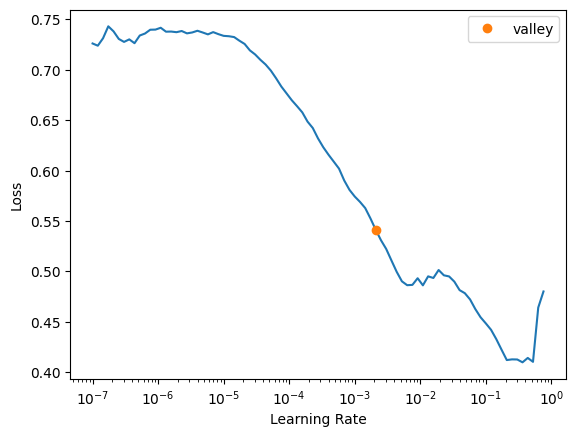

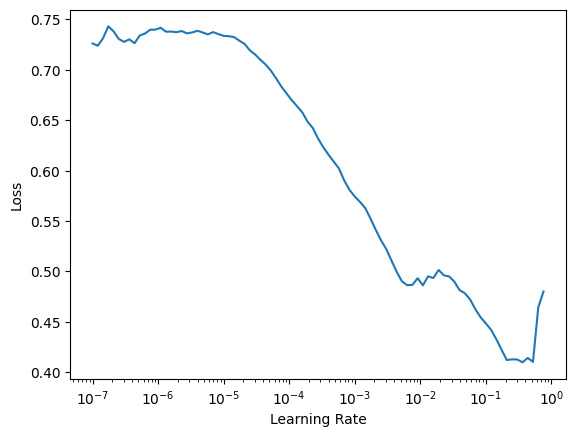

In [ ]:
# Find the optimal learning rate
learn.lr_find()
learn.recorder.plot_lr_find()

In [ ]:
optimal_lr = 1e-3

# Train the model
learn.fit_one_cycle(3, optimal_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.019959,0.361269,0.830508,00:00
1,0.020198,0.361805,0.864407,00:00
2,0.020941,0.377231,0.864407,00:00


In [ ]:
# Ensure the test dataset is preprocessed similarly
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        if test_df[col].dtype == 'object':
            test_df[col].fillna(test_df[col].mode()[0], inplace=True)
        else:
            test_df[col].fillna(test_df[col].median(), inplace=True)

In [ ]:
from sklearn.metrics import accuracy_score

# Create test TabularDataLoaders
dls_test = dls_train.test_dl(test_df)

# Get predictions and targets
preds, targets = learn.get_preds(dl=dls_test)

# Convert predictions to class labels
pred_labels = preds.argmax(dim=1)

# Calculate accuracy
test_accuracy = accuracy_score(targets, pred_labels)
print(f'Test Set Accuracy: {test_accuracy:.4f}')

Test Set Accuracy: 0.7333


**Save the results**

In [ ]:
learn.export('nph_vs_nc_saved_model.pkl')

In [ ]:
learn = load_learner('nph_vs_nc_saved_model.pkl')

In [ ]:
param_names = list(learn.model.parameters())
print(param_names)

[Parameter containing:
tensor([[-0.0110, -0.0077,  0.0184,  ..., -0.0014, -0.0033, -0.0037],
        [ 0.0170, -0.0250, -0.0370,  ..., -0.0035,  0.0260, -0.0067],
        [ 0.0215, -0.0231, -0.0066,  ..., -0.0192,  0.0176, -0.0342],
        ...,
        [-0.1203,  0.1181,  0.1076,  ...,  0.1054, -0.1475,  0.1279],
        [-0.0805,  0.1175,  0.1225,  ...,  0.1303, -0.1028,  0.0812],
        [-0.0813,  0.0773,  0.0827,  ...,  0.0712, -0.0549,  0.0543]], requires_grad=True), Parameter containing:
tensor([[ 0.0031,  0.0070, -0.0055],
        [ 0.3118,  0.3376,  0.2750],
        [-0.2955, -0.3310, -0.2454],
        [-0.2644, -0.2850, -0.1924]], requires_grad=True), Parameter containing:
tensor([[ 0.0017, -0.0114, -0.0013],
        [ 0.2827,  0.3148,  0.3546],
        [-0.2990, -0.3160, -0.3415]], requires_grad=True), Parameter containing:
tensor([0.9904, 0.9955, 1.0102,  ..., 0.9548, 0.9829, 1.4893], requires_grad=True), Parameter containing:
tensor([-0.0428, -0.0248,  0.0412,  ..., -0.052